# 0. Предварительная подготовка

In [44]:
import gc
import json
import os
import re
import textwrap
import warnings
from functools import lru_cache

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
from IPython.display import display
from nltk.corpus import stopwords
from pandarallel import pandarallel
from pymorphy3 import MorphAnalyzer
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import (
    enable_halving_search_cv,  # noqa: F401, необходимо для использования экспериментальной функции  # noqa
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from transformers import AutoModel, AutoTokenizer, pipeline


In [ ]:
# Фиксируем random state
rstate = 42
# Это предупреждение относится к зависимостям сторонних библиотек.
# Для учебных целей игнорируем
os.environ["PYTHONWARNINGS"] = "ignore:pkg_resources is deprecated"
# Отключаем все предупреждения об изменениях в будущих версиях библиотек
warnings.filterwarnings("ignore", category=FutureWarning)

In [46]:
DATA_URL = "https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz"
DATA_PATH = "lenta-ru-news.csv.gz"

if not os.path.exists(DATA_PATH):
    print(f"Файл {DATA_PATH} не найден, скачиваю из {DATA_URL}")
    response = requests.get(DATA_URL, stream=True, timeout=60)
    if response.status_code != 200:
        raise RuntimeError(f"Не удалось скачать датасет: HTTP {response.status_code}")
    with open(DATA_PATH, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Загрузка завершена")
else:
    print(f"Используем локальный файл {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

# Удаляем строки с пропусками
initial_rows = len(df)
df.dropna(subset=["title", "text", "topic"], inplace=True)
dropped_rows = initial_rows - len(df)
print(f"Удалено строк с пропусками: {dropped_rows} ({dropped_rows / initial_rows * 100:.2g} %)")

# Оставим только нужные колонки
df = df[["title", "text", "topic"]]
print(df.info())
print()
print(df.head())

Используем локальный файл lenta-ru-news.csv.gz
Удалено строк с пропусками: 208 (0.028 %)
<class 'pandas.core.frame.DataFrame'>
Index: 739143 entries, 0 to 739350
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   739143 non-null  object
 1   text    739143 non-null  object
 2   topic   739143 non-null  object
dtypes: object(3)
memory usage: 22.6+ MB
None

                                               title  \
0  Названы регионы России с самой высокой смертно...   
1  Австрия не представила доказательств вины росс...   
2       Обнаружено самое счастливое место на планете   
3  В США раскрыли сумму расходов на расследование...   
4  Хакеры рассказали о планах Великобритании зами...   

                                                text        topic  
0  Вице-премьер по социальным вопросам Татьяна Го...       Россия  
1  Австрийские правоохранительные органы не предс...        Спорт  
2  Сотрудники социальной сети Ins

# 1. Hugging Face и pipeline API

In [47]:
# Для проверки выберем 5 новостей
indices_to_summarize = [1, 40, 100, 500, 1000]
texts_from_dataset = df.loc[indices_to_summarize]["text"].tolist()

# Добавим 3 примера out-of-domain

# Стихи
poem = """Ночь, улица, фонарь, аптека,
          Бессмысленный и тусклый свет.
          Живи еще хоть четверть века -
          Всё будет так. Исхода нет.
          
          Умрешь - начнешь опять сначала
          И повторится всё, как встарь:
          Ночь, ледяная рябь канала,
          Аптека, улица, фонарь."""

# Переписка
texting = """А: Привет! Ты вчера до скольки сидел?
             Б: Привет. Почти до двух ночи.
             А: Жесть.
             Б: Не то слово. Зато, кажется, я нашел тот баг с авторизацией.
             А: Серьезно? Который два дня искали?
             Б: Да.
             А: И что там было?
             Б: Банально. В одном из env-файлов не хватало ключа.
             А: В смысле?
             Б: Ну, в .env.local он был, а в .env.prod – нет.
             А: И деплой шел с prod-конфигом?
             Б: Именно. А локально у всех все работало.
             А: Классика. Я же говорил, что надо конфиги проверить.
             Б: Говорил. Но кто ж думал, что так тупо."""

# Текст объявления с Авито (авторская орфография и пунктуация)
short_text = "Разминочный костюм BJORN DAEHLIE ,состояние новой вещи,без каких -либо следов износа.По бирке xl,но в реале L,замеры на фото,ориентируйтесь по ним.Произведено в России,но качества материала,пошива и лекала на высоте...Красивый яркий комбинезон."

texts_from_dataset.extend([poem, texting, short_text])

In [48]:
summarizer = pipeline("summarization", model="IlyaGusev/rut5_base_sum_gazeta")


# Функция для форматирования вывода 4 строки максимум по 120 символов
def wrapper(text: str) -> str:
    return textwrap.fill(text, width=120, max_lines=4, placeholder="...")


for i, text in enumerate(texts_from_dataset, start=1):
    # Генерируем саммари
    summary = summarizer(text, max_length=300, min_length=30, do_sample=False)

    # Вывод в читаемом формате
    print("\n" + "=" * 120 + "\n")
    print(f"--- Пример № {i} ---")
    print(f"Оригинал:\n{wrapper(text)}")
    print("\n")
    print(f"Суммаризация:\n{wrapper(summary[0]['summary_text'])}")
    print(f"\nИзменение размера: {len(text)} -> {len(summary[0]['summary_text'])}")

Device set to use cuda:0




--- Пример № 1 ---
Оригинал:
Австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых
правил. Об этом сообщил посол России в Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии с
представителями прокуратуры страны, передает ТАСС. «Действует презумпция невиновности. Каких-либо ограничений свободы
передвижения для команды нет», — добавили в посольстве. Международный союз биатлонистов (IBU) также не будет...


Суммаризация:
Австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых
правил. Международный союз биатлонистов (IBU) также не будет применять санкции к российским биатлонистам. Международный
союз биатлонистов (IBU) также не будет применять санкции к российским биатлонистам.

Изменение размера: 1072 -> 321


--- Пример № 2 ---
Оригинал:
В Московском районе Санкт-Петербурга на продажу выставлена доля в 58-комнатной квартире. Об этом в свое

Your max_length is set to 300, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)




--- Пример № 5 ---
Оригинал:
Российский скелетонист Никита Трегубов победил на этапе Кубка мира в Латвии. Он обошел хозяина трассы Мартинса Дукурса,
сообщает ТАСС. По итогам двух заездов 23-летний россиянин показал результат 1 минута 41,87 секунды. Дукурс занял второе
место и отстал на 0,37 секунды. Третьим стал действующий обладатель Кубка мира южнокореец Юн Сон Бин (плюс 0,53). Для
Трегубова эта победа стала первой в карьере на этапах Кубка мира. На Олимпиаде 2018 года он завоевал серебряную...


Суммаризация:
Российский скелетонист Никита Трегубов победил на этапе Кубка мира в Латвии. 23-летний россиянин показал результат 1
минута 41,87 секунды и отстал на 0,37 секунды. Третьим стал действующий обладатель Кубка мира южнокореец Юн Сон Бин
(плюс 0,53). Третьим стал действующий обладатель Кубка мира южнокореец Юн Сон Бин (плюс 0,53).

Изменение размера: 1064 -> 327


Your max_length is set to 300, but your input_length is only 205. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=102)




--- Пример № 6 ---
Оригинал:
Ночь, улица, фонарь, аптека,           Бессмысленный и тусклый свет.           Живи еще хоть четверть века -
Всё будет так. Исхода нет.            Умрешь - начнешь опять сначала           И повторится всё, как встарь:
Ночь, ледяная рябь канала,           Аптека, улица, фонарь.


Суммаризация:
Ночь, улица, фонарь, аптека, Бессмысленный и тусклый свет. Живи еще четверть века - Всё будет так. Исхода нет. Исхода
нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода
нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет.

Изменение размера: 297 -> 326


Your max_length is set to 300, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)




--- Пример № 7 ---
Оригинал:
А: Привет! Ты вчера до скольки сидел?              Б: Привет. Почти до двух ночи.              А: Жесть.              Б:
Не то слово. Зато, кажется, я нашел тот баг с авторизацией.              А: Серьезно? Который два дня искали?
Б: Да.              А: И что там было?              Б: Банально. В одном из env-файлов не хватало ключа.              А:
В смысле?              Б: Ну, в .env.local он был, а в .env.prod – нет.              А: И деплой шел с prod-конфигом?...


Суммаризация:
Вчера я нашел тот баг с авторизацией, который нашел я.env.local, а в одном из файлов не хватало ключа, а в одном из
файлов не хватало ключа. А в одном из файлов не хватало ключа, а в одном из env-файлов не хватало ключа.

Изменение размера: 661 -> 220


--- Пример № 8 ---
Оригинал:
Разминочный костюм BJORN DAEHLIE ,состояние новой вещи,без каких -либо следов износа.По бирке xl,но в реале L,замеры на
фото,ориентируйтесь по ним.Произведено в России,но качества материала,пошива 

## Выводы

Тестирование модели `IlyaGusev/rut5_base_sum_gazeta` показало:

1.  **Новости (целевой домен):**
    * Модель хорошо справляется с новостными статьями, корректно передавая их суть и ключевые факты.
    * Основной недостаток — периодические повторы предложений в сгенерированных саммари.

2.  **Другие домены (out-of-domain):**
    * Модель не справляется с нецелевыми форматами, что ожидаемо, так как она обучалась на новостях.
    * **Стихи:** Генерируется набор повторяющихся фраз.
    * **Диалог:** Попытка связного текста приводит к бессмыслице и искажению фактов.
    * **Объявление:** Короткий текст обрабатывается неверно, с генерацией нелогичных фрагментов.

In [49]:
# --- Очистка памяти после суммаризации ---
try:
    del summarizer
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Модель суммаризации выгружена, память очищена.")
except NameError:
    print("Модель суммаризации не была загружена, очистка не требуется.")

Модель суммаризации выгружена, память очищена.


# 2. Анализ эмбеддингов трансформерных моделей

In [50]:
# отключаем форматтер для читаемости inline комментариев
# fmt: off

# Предложения для обработки
# Три связанные пары и четыре предложения без пар
sentences = [
    "Автомобиль едет быстро.",                      # 0  - Пара №1
    "Машина мчится на большой скорости.",           # 1  - Пара №1
    "Сегодня хорошая погода.",                      # 2  - Пара №2
    "На улице отличный денек.",                     # 3  - Пара №2
    "Королева была недовольна.",                    # 4  - Пара №3
    "Ее величество пребывала в дурном настроении.", # 5  - Пара №3
    "Космонавты готовятся к полету на Марс.",       # 6  - без пары
    "В лесу выросли грибы.",                        # 7  - без пары
    "Этот рецепт пирога очень простой.",            # 8  - без пары
    "Квантовая физика - сложная наука.",            # 9  - без пары
]

In [51]:
# Обертка для удобного расчета косинусного сходства между двумя векторами
def get_cos_sim(vec1, vec2):
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0, 0]

## 2.1 Bert-based модель

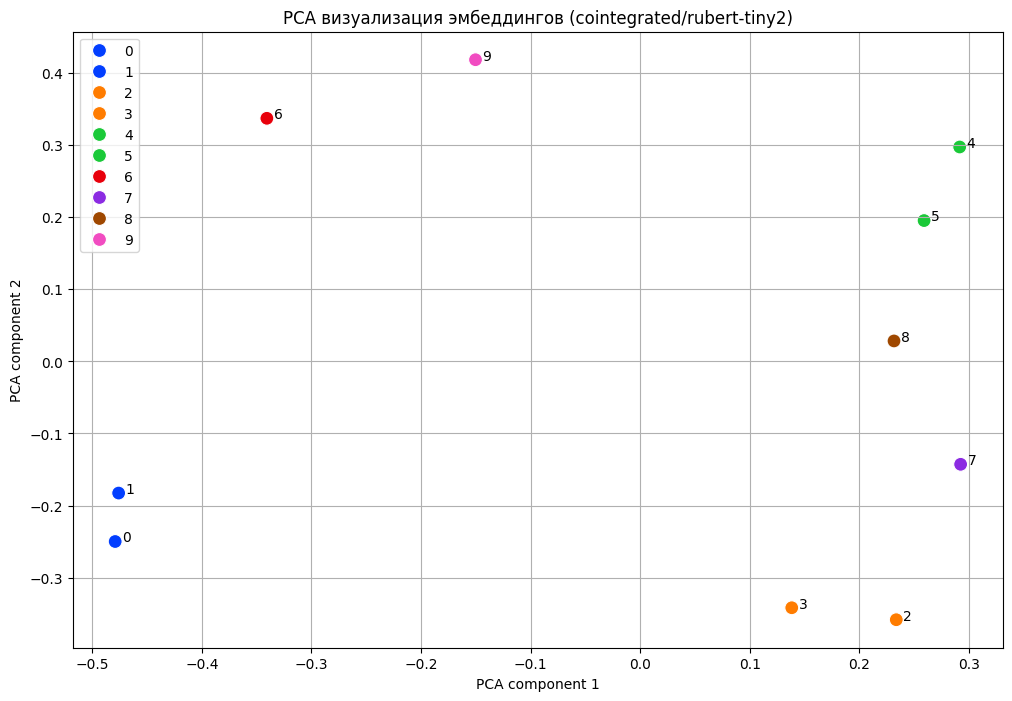

Косинусное сходство для пар:
Пара №1 (0-1) ('Автомобиль' vs 'Машина'): 0.8338
Пара №2 (2-3) ('Погода' vs 'Денек'): 0.6983
Пара №3 (4-5) ('Королева' vs 'Величество'): 0.6825

Косинусное сходство для не связанных предложений:
'Автомобиль'(0) vs 'Квантовая физика'(9): 0.4167
'Погода'(2) vs 'Грибы'(7): 0.5388


In [52]:
bert_model_name = "cointegrated/rubert-tiny2"
bert_model = SentenceTransformer(bert_model_name)
bert_embeddings = bert_model.encode(sentences)

# Визуализация с помощью PCA
pca = PCA(n_components=2, random_state=rstate)
bert_embeddings_2d = pca.fit_transform(bert_embeddings)

plt.figure(figsize=(12, 8))
# Назначим одинаковые цвета для пар синонимов, чтобы их было легче отличить
palette = sns.color_palette("bright", 10)
colors = [
    palette[0],
    palette[0],
    palette[1],
    palette[1],
    palette[2],
    palette[2],
    palette[3],
    palette[4],
    palette[5],
    palette[6],
]

sns.scatterplot(
    x=bert_embeddings_2d[:, 0],
    y=bert_embeddings_2d[:, 1],
    hue=[str(i) for i in range(len(sentences))],
    palette=colors,
    legend="full",
    s=100,
)

for i, _ in enumerate(sentences):
    plt.annotate(i, (bert_embeddings_2d[i, 0], bert_embeddings_2d[i, 1]), textcoords="offset points", xytext=(5, 0))

plt.title(f"PCA визуализация эмбеддингов ({bert_model_name})")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.grid(True)
plt.show()

print("Косинусное сходство для пар:")
print(f"Пара №1 (0-1) ('Автомобиль' vs 'Машина'): {get_cos_sim(bert_embeddings[0], bert_embeddings[1]):.4f}")
print(f"Пара №2 (2-3) ('Погода' vs 'Денек'): {get_cos_sim(bert_embeddings[2], bert_embeddings[3]):.4f}")
print(f"Пара №3 (4-5) ('Королева' vs 'Величество'): {get_cos_sim(bert_embeddings[4], bert_embeddings[5]):.4f}")

print("\nКосинусное сходство для не связанных предложений:")
print(f"'Автомобиль'(0) vs 'Квантовая физика'(9): {get_cos_sim(bert_embeddings[0], bert_embeddings[9]):.4f}")
print(f"'Погода'(2) vs 'Грибы'(7): {get_cos_sim(bert_embeddings[2], bert_embeddings[7]):.4f}")

## GPT-based модель

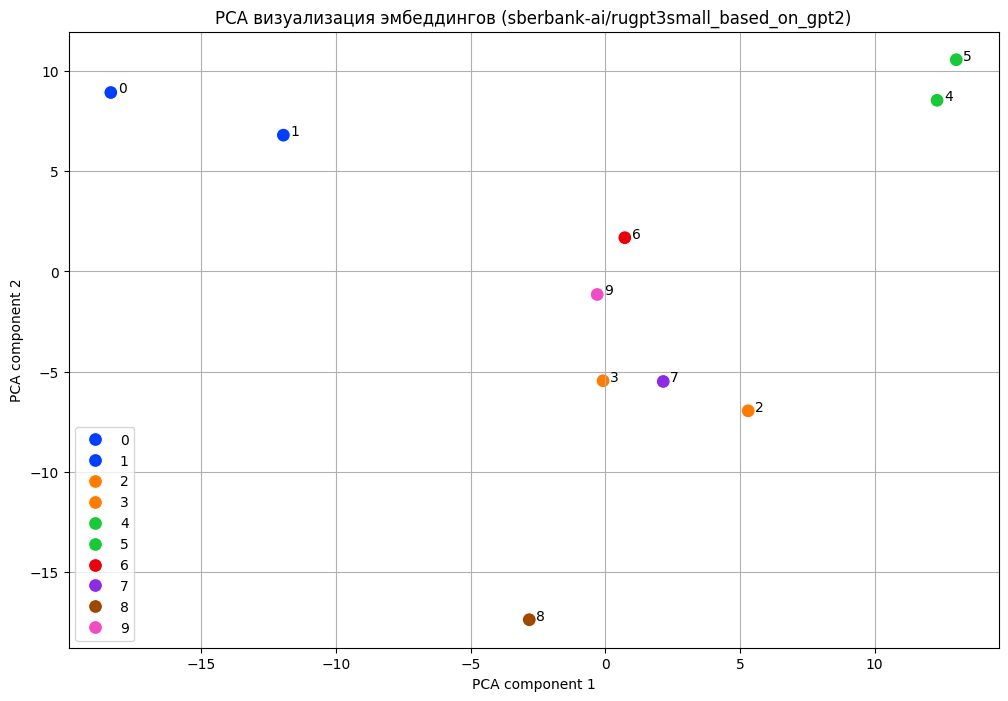

Косинусное сходство для пар:
Пара №1 (0-1) ('Автомобиль' vs 'Машина'): 0.6386
Пара №2 (2-3) ('Погода' vs 'Денек'): 0.6216
Пара №3 (4-5) ('Королева' vs 'Величество'): 0.5629

Косинусное сходство для не связанных предложений:
'Автомобиль'(0) vs 'Квантовая физика'(9): 0.3851
'Погода'(2) vs 'Грибы'(7): 0.4756


In [53]:
gpt_model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_model_name)
gpt_model = AutoModel.from_pretrained(gpt_model_name)


# Функция для получения эмбеддингов из GPT
def get_gpt_embeddings(sentences, tokenizer, model):
    # Токенизация
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

    # Получение эмбеддингов
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Усреднение токенов для получения эмбеддинга предложения (mean pooling)
    attention_mask = encoded_input["attention_mask"]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_output.last_hidden_state.size()).float()
    sum_embeddings = torch.sum(model_output.last_hidden_state * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    return (sum_embeddings / sum_mask).numpy()


# Запуск генерации эмбеддингов
gpt_embeddings = get_gpt_embeddings(sentences, gpt_tokenizer, gpt_model)

# Визуализация с помощью PCA
pca = PCA(n_components=2, random_state=rstate)
gpt_embeddings_2d = pca.fit_transform(gpt_embeddings)

plt.figure(figsize=(12, 8))
palette = sns.color_palette("bright", 10)
colors = [
    palette[0],
    palette[0],
    palette[1],
    palette[1],
    palette[2],
    palette[2],
    palette[3],
    palette[4],
    palette[5],
    palette[6],
]
sns.scatterplot(
    x=gpt_embeddings_2d[:, 0],
    y=gpt_embeddings_2d[:, 1],
    hue=[str(i) for i in range(len(sentences))],
    palette=colors,
    legend="full",
    s=100,
)
for i, _ in enumerate(sentences):
    plt.annotate(i, (gpt_embeddings_2d[i, 0], gpt_embeddings_2d[i, 1]), textcoords="offset points", xytext=(5, 0))
plt.title(f"PCA визуализация эмбеддингов ({gpt_model_name})")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.grid(True)
plt.show()

# --- Расчет косинусного сходства ---
print("Косинусное сходство для пар:")
print(f"Пара №1 (0-1) ('Автомобиль' vs 'Машина'): {get_cos_sim(gpt_embeddings[0], gpt_embeddings[1]):.4f}")
print(f"Пара №2 (2-3) ('Погода' vs 'Денек'): {get_cos_sim(gpt_embeddings[2], gpt_embeddings[3]):.4f}")
print(f"Пара №3 (4-5) ('Королева' vs 'Величество'): {get_cos_sim(gpt_embeddings[4], gpt_embeddings[5]):.4f}")

print("\nКосинусное сходство для не связанных предложений:")
print(f"'Автомобиль'(0) vs 'Квантовая физика'(9): {get_cos_sim(gpt_embeddings[0], gpt_embeddings[9]):.4f}")
print(f"'Погода'(2) vs 'Грибы'(7): {get_cos_sim(gpt_embeddings[2], gpt_embeddings[7]):.4f}")

## Выводы

Сравнивались две модели: `cointegrated/rubert-tiny2` (BERT) и `sberbank-ai/rugpt3small_based_on_gpt2` (GPT). Для GPT эмбеддинг предложения рассчитывался как среднее его токенов.

1.  **Визуализация (PCA):**
    * **Ограничение PCA**: Агрессивное снижение размерности (до 2D) на малой выборке может искажать картину, поэтому выводы на основе визуализации предварительны.
    * **BERT**: Показал четкую кластеризацию. Синонимичные пары расположены близко, предложения с разным смыслом — далеко.
    * **GPT**: Структура менее четкая. Синонимы сгруппированы, однако некоторые несинонимичные пары также расположены близко к ним и друг к другу.

2.  **Косинусное сходство:**
    * **BERT**: Высокое сходство для синонимов (~0.7-0.8) и низкое для разных по смыслу предложений.
    * **GPT**: Сходство для синонимов ниже, чем у BERT. Разница (дельта) между средним сходством синонимов и не-синонимов также меньше, что указывает на худшую различительную способность.

**Общий вывод:** Обе модели формируют ожидаемые эмбеддинги (близкие для схожих, далекие для различных). Несмотря на ограничения (малая выборка, агрессивное PCA), эксперимент подтверждает, что BERT-архитектуры (энкодеры) лучше подходят для задач семантического сравнения, чем GPT-архитектуры (декодеры), оптимизированные для генерации текста.

In [54]:
# --- Очистка памяти после анализа эмбеддингов ---
try:
    del bert_model
    del gpt_model
    del bert_embeddings
    del gpt_embeddings
    del bert_embeddings_2d
    del gpt_embeddings_2d
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Модели для анализа эмбеддингов выгружены, память очищена.")
except NameError:
    print("Модели для анализа эмбеддингов не были загружены, очистка не требуется.")

Модели для анализа эмбеддингов выгружены, память очищена.


# 3. Сравнение с классическими методами NLP

### 3.1 Подготовка данных

In [55]:
# --- Исходные параметры ---
sampling = True  # флаг запуска опционального сэмплирования

# --- 1. Очистка топиков ---
df["topic"] = df["topic"].str.lower().str.strip()

# --- 2. Отбрасываем редкие темы ---
min_samples = 200
topic_counts = df["topic"].value_counts()
topics_to_keep = topic_counts[topic_counts >= min_samples].index
topics_to_drop = topic_counts[topic_counts < min_samples].index
print(f"Список отброшенных тем: {list(topics_to_drop)}")

# Отбрасываем записи с редкими темами
df.drop(df[~df["topic"].isin(topics_to_keep)].index, inplace=True)
dropped_rare_rows = initial_rows - len(df)

# --- 3. Сэмплирование 2% со стратификацией по теме ---
if sampling:
    sample_share = 0.02
    _, df_sample = train_test_split(df, test_size=sample_share, stratify=df["topic"], random_state=rstate)
    df = df_sample
    print(f"Размер стратифицированной подвыборки: {len(df)}")

# --- 4. Разделим данные ---
df_tfidf = df.copy()  # для предобработки и TF-IDF
df_raw = df.copy()  # для других моделей

# Сохраним часть данных
output_df_raw_path = "processed_data_raw.pkl"
df_raw.to_pickle(output_df_raw_path)

# --- 5. Настройка нормализации ---

# Загружаем список стоп-слов, если нет в кэше
try:
    stopwords.words("russian")
except LookupError:
    nltk.download("stopwords")

russian_stopwords = set(stopwords.words("russian"))  # преобразуем к set для константного времени поиска
morph = MorphAnalyzer()
token_pattern = re.compile(r"[а-яёa-z]+", re.IGNORECASE)  # паттерн токена - только буквы алфавитов


# Функция лемматизации с кэшированием
@lru_cache(maxsize=100_000)
def lemmatize(token: str) -> str:
    parsed = morph.parse(token)[0]
    return parsed.normal_form


# Функция нормализации
def normalize_text(text: str) -> str:
    tokens = token_pattern.findall(text.lower())
    lemmas = (lemmatize(token) for token in tokens)
    cleaned = [lemma for lemma in lemmas if lemma not in russian_stopwords]
    return " ".join(cleaned)


# --- 6. Нормализация ---
print("Запуск нормализации текста...")
pandarallel.initialize(progress_bar=True, verbose=0)
temp_content_series = df_tfidf["title"] + " " + df_tfidf["text"]
df_tfidf["content_clean"] = temp_content_series.apply(normalize_text)
df_tfidf.drop(columns=["title", "text"], inplace=True)
print("Нормализация завершена.")

# --- 7. Кодирование целевой переменной ---
label_encoder = LabelEncoder()
df_tfidf["topic_encoded"] = label_encoder.fit_transform(df_tfidf["topic"])

# --- 8. Сохранение результатов ---
print("Сохранение результатов...")

# 8.1 Сохраняем обработанный DataFrame
output_df_tfidf_path = "processed_data_tfidf.pkl"
df_tfidf.to_pickle(output_df_tfidf_path)

# 8.2 Создаем и сохраняем словарь закодированных тем
topic_to_id_map = {
    topic: int(idx)
    for topic, idx in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_), strict=False)
}

output_map_path = "topic_to_id_map.json"
with open(output_map_path, "w", encoding="utf-8") as f:
    json.dump(topic_to_id_map, f, ensure_ascii=False, indent=4)

print(f"Обработанный DataFrame c предобработкой для TF-IDF сохранен в: {output_df_tfidf_path}")
print(f"DataFrame без предобработки сохранен в: {output_df_raw_path}")
print(f"Словарь 'topic: id' сохранен в: {output_map_path}")

Список отброшенных тем: ['легпром', 'библиотека', 'оружие', 'чм-2014', 'медновости', 'сочи']
Размер стратифицированной подвыборки: 14780
Запуск нормализации текста...
Нормализация завершена.
Сохранение результатов...
Обработанный DataFrame c предобработкой для TF-IDF сохранен в: processed_data_tfidf.pkl
DataFrame без предобработки сохранен в: processed_data_raw.pkl
Словарь 'topic: id' сохранен в: topic_to_id_map.json


In [56]:
# --- 1. Чтение сохраненных данных ---

tfidf_path = "processed_data_tfidf.pkl"
raw_path = "processed_data_raw.pkl"
map_path = "topic_to_id_map.json"

df_tfidf = pd.read_pickle(tfidf_path)
df_raw = pd.read_pickle(raw_path)

with open(map_path, encoding="utf-8") as f:
    topic_to_id_map = json.load(f)

# --- 2. Разделение по индексам ---

# Получаем индексы и таргеты для стратификации
indices = df_tfidf.index
y = df_tfidf["topic"]

# Разделяем данные на тренировочную (60%), тестовую (20%) и валидационную выборку (20%)
idx_train, idx_temp, y_train, y_temp = train_test_split(
    indices,
    y,
    test_size=0.4,
    random_state=rstate,
    stratify=y,
)

idx_val, idx_test, y_val, y_test = train_test_split(
    idx_temp,
    y_temp,
    test_size=0.5,
    random_state=rstate,
    stratify=y_temp,
)

# --- 4. Создание финальных выборок ---

# 4.1 Для TF-IDF
X_tfidf_train = df_tfidf.loc[idx_train, "content_clean"]
X_tfidf_val = df_tfidf.loc[idx_val, "content_clean"]
X_tfidf_test = df_tfidf.loc[idx_test, "content_clean"]

# 4.2 Для сырых данных
X_raw_train = df_raw.loc[idx_train, ["text"]]
X_raw_val = df_raw.loc[idx_val, ["text"]]
X_raw_test = df_raw.loc[idx_test, ["text"]]

# 4.3 Метки классов одинаковые для обоих подходов
y_train = df_tfidf.loc[idx_train, "topic_encoded"]
y_val = df_tfidf.loc[idx_val, "topic_encoded"]
y_test = df_tfidf.loc[idx_test, "topic_encoded"]

# --- 5. Вывод и проверка ---
print("\nРазмеры выборок:")
print(f"- Тренировочная (train): {len(X_tfidf_train)} (TF-IDF) / {len(X_raw_train)} (Raw)")
print(f"- Валидационная (val): {len(X_tfidf_val)} (TF-IDF) / {len(X_raw_val)} (Raw)")
print(f"- Тестовая (test): {len(X_tfidf_test)} (TF-IDF) / {len(X_raw_test)} (Raw)")


Размеры выборок:
- Тренировочная (train): 8868 (TF-IDF) / 8868 (Raw)
- Валидационная (val): 2956 (TF-IDF) / 2956 (Raw)
- Тестовая (test): 2956 (TF-IDF) / 2956 (Raw)


### 3.2 TF-IDF + LogisticRegression

In [57]:
# 1. Определяем пайплайн (
pipeline_tfidf = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        (
            "classifier",
            LogisticRegression(
                max_iter=500,
                solver="liblinear",
                random_state=rstate,
            ),
        ),
    ]
)

# 2. Определяем сетку параметров для этого пайплайна
param_grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__max_features": [300, 1000],
    "vectorizer__min_df": [1, 2],
    "classifier__penalty": ["l1"],
    "classifier__C": [0.5, 1.0],
}

# 3. Подбор гиперпараметров
grid_search = HalvingGridSearchCV(
    estimator=pipeline_tfidf,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0,
    min_resources="exhaust",
    factor=3,
)

grid_search.fit(X_tfidf_train, y_train)

# 4. Сохраняем лучшую модель
best_pipeline_tfidf = grid_search.best_estimator_

# 5. Считаем и выводим метрики
y_train_pred = best_pipeline_tfidf.predict(X_tfidf_train)
train_acc = accuracy_score(y_train, y_train_pred)

y_val_pred = best_pipeline_tfidf.predict(X_tfidf_val)
val_acc = accuracy_score(y_val, y_val_pred)

print("\n--- Итоговые результаты ---")
print("Модель: LogisticRegression + TfidfVectorizer")
print(f"Train accuracy: {train_acc:.4f}")
print(f"Val accuracy: {val_acc:.4f}")


--- Итоговые результаты ---
Модель: LogisticRegression + TfidfVectorizer
Train accuracy: 0.7660
Val accuracy: 0.7246


### 3.3 Подход 2: Sentence Transformers + LogisticRegression

In [58]:
# 1. Загрузка модели
st_model_name = "cointegrated/rubert-tiny2"
st_model = SentenceTransformer(st_model_name)

# 2. Получение эмбеддингов
print("Генерация эмбеддингов для train-выборки...")
X_st_train_embeddings = st_model.encode(X_raw_train["text"].tolist(), show_progress_bar=True)

print("Генерация эмбеддингов для val-выборки...")
X_st_val_embeddings = st_model.encode(X_raw_val["text"].tolist(), show_progress_bar=True)

# 3. Обучение
log_reg_st = LogisticRegression(max_iter=500, solver="liblinear", random_state=rstate)
log_reg_st.fit(X_st_train_embeddings, y_train)

# 4. Оценка тренировочной и валидационной выборке
y_val_pred_st = log_reg_st.predict(X_st_val_embeddings)
val_acc_st = accuracy_score(y_val, y_val_pred_st)

y_train_pred_st = log_reg_st.predict(X_st_train_embeddings)
train_acc_st = accuracy_score(y_train, y_train_pred_st)


print("\n--- Итоговые результаты ---")
print("Модель: Sentence Transformers + LogisticRegression")
print(f"Train accuracy: {train_acc_st:.4f}")
print(f"Val accuracy: {val_acc_st:.4f}")

Генерация эмбеддингов для train-выборки...


Batches:   0%|          | 0/278 [00:00<?, ?it/s]

Генерация эмбеддингов для val-выборки...


Batches:   0%|          | 0/93 [00:00<?, ?it/s]


--- Итоговые результаты ---
Модель: Sentence Transformers + LogisticRegression
Train accuracy: 0.7401
Val accuracy: 0.7395


In [59]:
# --- Очистка памяти после SentenceTransformer ---
try:
    del X_st_train_embeddings
    del X_st_val_embeddings
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Память очищена.")
except NameError:
    print("Промежуточные эмбеддинги не были загружены, очистка не требуется.")

Память очищена.


### 3.4 Подход 3: Zero-Shot Classification

In [60]:
# --- 1. Кофигурация pipeline ---
zero_shot_model_name = "cointegrated/rubert-base-cased-nli-threeway"
zero_shot_classifier = pipeline(
    "zero-shot-classification",
    model=zero_shot_model_name,
    device=0 if torch.cuda.is_available() else -1,
)

# --- 2. Подготовка данных ---

# Объединим train и val, для zero-shot разделение бессмысленно
X_train_test = pd.concat([X_raw_train, X_raw_val])["text"].tolist()
y_train_test = pd.concat([y_train, y_val]).tolist()

# Создаем обратный маппинг из id в topic
candidate_labels = list(topic_to_id_map.keys())
id_to_topic_map = {v: k for k, v in topic_to_id_map.items()}

# --- 3. Запуск классификации и оценка результатов---
input_generator = (text for text in X_train_test)
results_zs_generator = zero_shot_classifier(
    input_generator,
    candidate_labels,
    multi_label=False,
    batch_size=92,  # NVIDIA GeForce RTX 3060 Ti, Dedicated GPU memory	6,0/8,0 GB на батч
)

# Извлекаем предсказанные метки из списка результатов
predictions_zs = list(tqdm(results_zs_generator, total=len(X_train_test)))

# Конвертируем предсказанные названия тем в их id
predicted_ids = [topic_to_id_map[label["labels"][0]] for label in predictions_zs]

# Считаем accuracy
accuracy_zs = accuracy_score(y_train_test, predicted_ids)

print("\n--- Итоговые результаты ---")
print(f"Модель: Zero-Shot Classification ({zero_shot_model_name})")
print(f"Train + Val accuracy: {accuracy_zs:.4f}")

Device set to use cuda:0


  0%|          | 0/11824 [00:00<?, ?it/s]


--- Итоговые результаты ---
Модель: Zero-Shot Classification (cointegrated/rubert-base-cased-nli-threeway)
Train + Val accuracy: 0.2361


In [72]:
# --- Очистка памяти после Zero-Shot Classification ---
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### 3.5 Сравнение результатов

In [ ]:
# --- 1. Оценка TF-IDF + LogisticRegression ---
print("Запуск и оценка  TF-IDF + LogisticRegression...")
y_test_pred_tfidf = best_pipeline_tfidf.predict(X_tfidf_test)
test_acc_tfidf = accuracy_score(y_test, y_test_pred_tfidf)
test_f1_tfidf = f1_score(y_test, y_test_pred_tfidf, average="weighted")
cm_tfidf = confusion_matrix(y_test, y_test_pred_tfidf)

# --- 2. Оценка Sentence Transformers + LogisticRegression ---
print("\nЗапуск и оценка Sentence Transformers + LogisticRegression...")
X_st_test_embeddings = st_model.encode(X_raw_test["text"].tolist(), show_progress_bar=True)
y_test_pred_st = log_reg_st.predict(X_st_test_embeddings)

# Оценка
test_acc_st = accuracy_score(y_test, y_test_pred_st)
test_f1_st = f1_score(y_test, y_test_pred_st, average="weighted")
cm_st = confusion_matrix(y_test, y_test_pred_st)

# Очистка памяти
try:
    del X_st_test_embeddings
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Память после Sentence Transformers очищена.")
except NameError:
    print("Промежуточные эмбеддинги не были загружены, очистка не требуется.")

# --- 3. Оценка Zero-Shot Classification ---
print("\nЗапуск и оценка Zero-Shot Classification...")
test_texts_list = X_raw_test["text"].tolist()
input_generator_test = (text for text in test_texts_list)
results_zs_test_generator = zero_shot_classifier(
    input_generator_test,
    candidate_labels,
    multi_label=False,
    batch_size=92,  # NVIDIA GeForce RTX 3060 Ti, Dedicated GPU memory	6,0/8,0 GB на батч
)
results_zs_test = list(tqdm(results_zs_test_generator, total=len(test_texts_list)))
predictions_zs_test = [result["labels"][0] for result in results_zs_test]

# Оценка
predicted_ids_zs_test = [topic_to_id_map[label] for label in predictions_zs_test]
test_acc_zs = accuracy_score(y_test, predicted_ids_zs_test)
test_f1_zs = f1_score(y_test, predicted_ids_zs_test, average="weighted")
cm_zs = confusion_matrix(y_test, predicted_ids_zs_test)

# Очистка памяти
try:
    del results_zs_test
    del predictions_zs_test
    del predicted_ids_zs_test
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Память после Zero-Shot Classification очищена.")
except NameError:
    print("Переменные для очистки не найдены или уже удалены.")

Запуск и оценка  TF-IDF + LogisticRegression...

Запуск и оценка Sentence Transformers + LogisticRegression...


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Память после Sentence Transformers очищена.

Запуск и оценка Zero-Shot Classification...


  0%|          | 0/2956 [00:00<?, ?it/s]

Память после Zero-Shot Classification очищена.


,Модель,Accuracy,F1-score (weighted)
0,TF-IDF + LogisticRegression,0.7334,0.7168
1,Sentence Transformers + LogisticRegression,0.7256,0.7053
2,Zero-Shot Classification,0.2341,0.2549


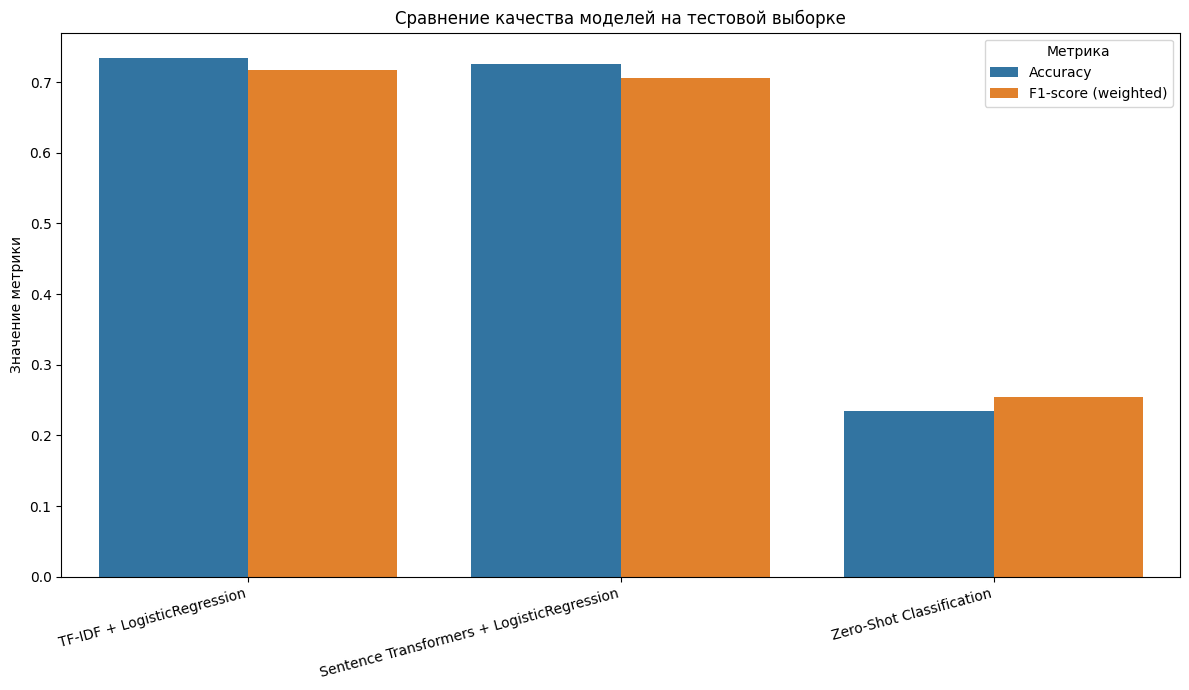

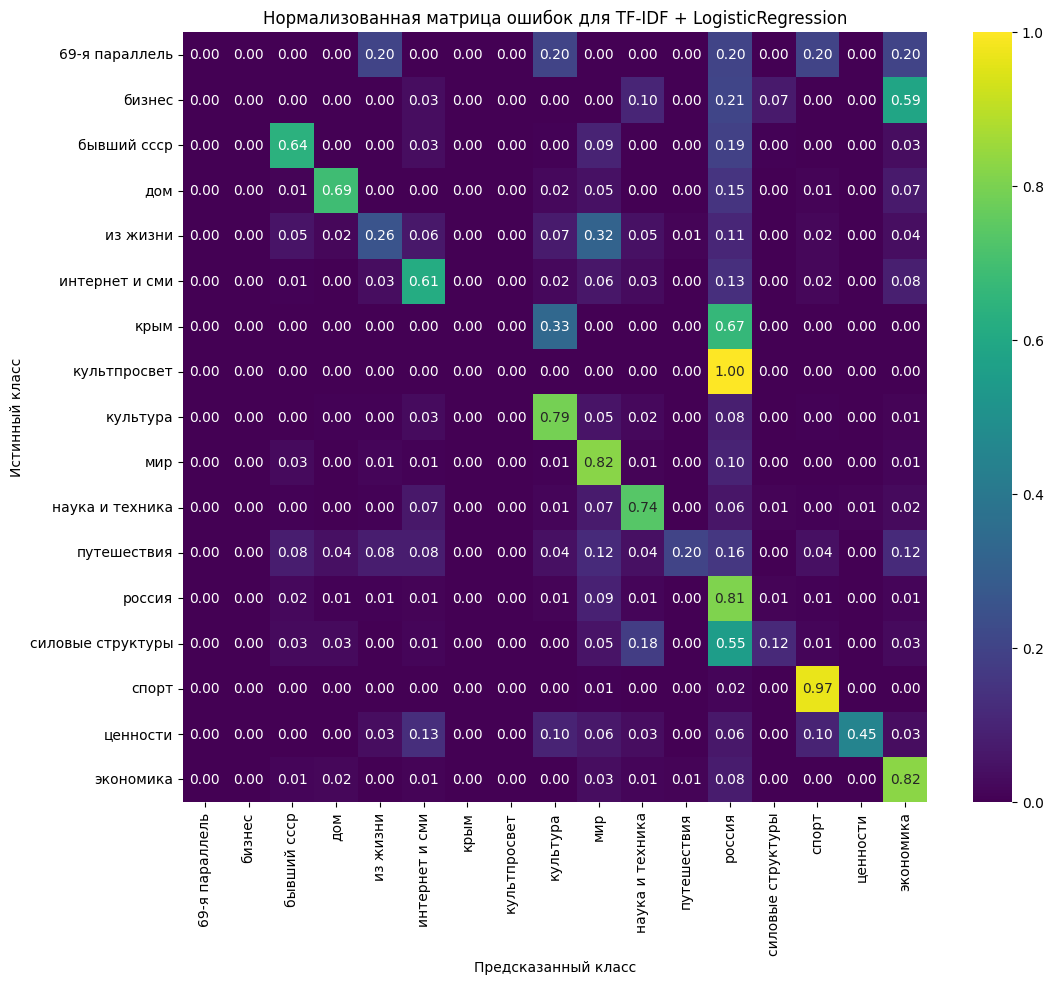

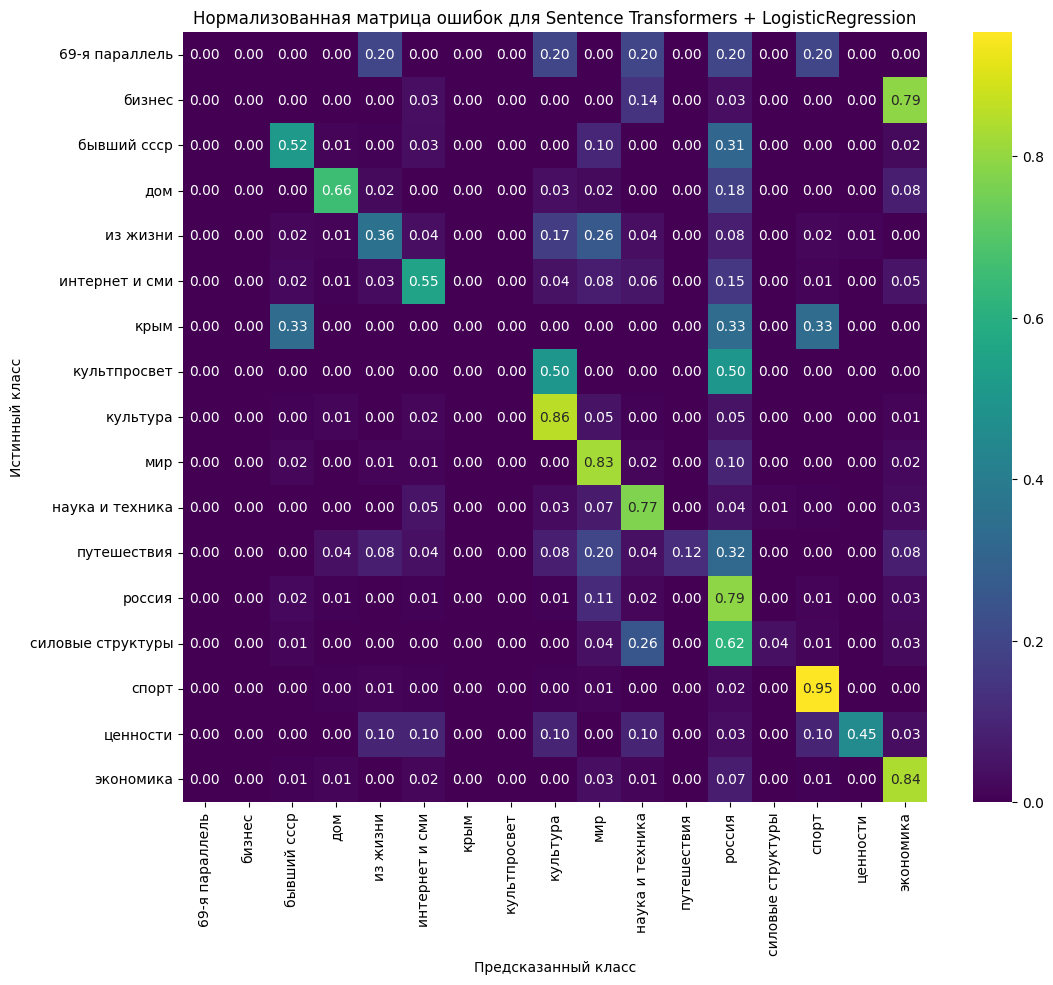

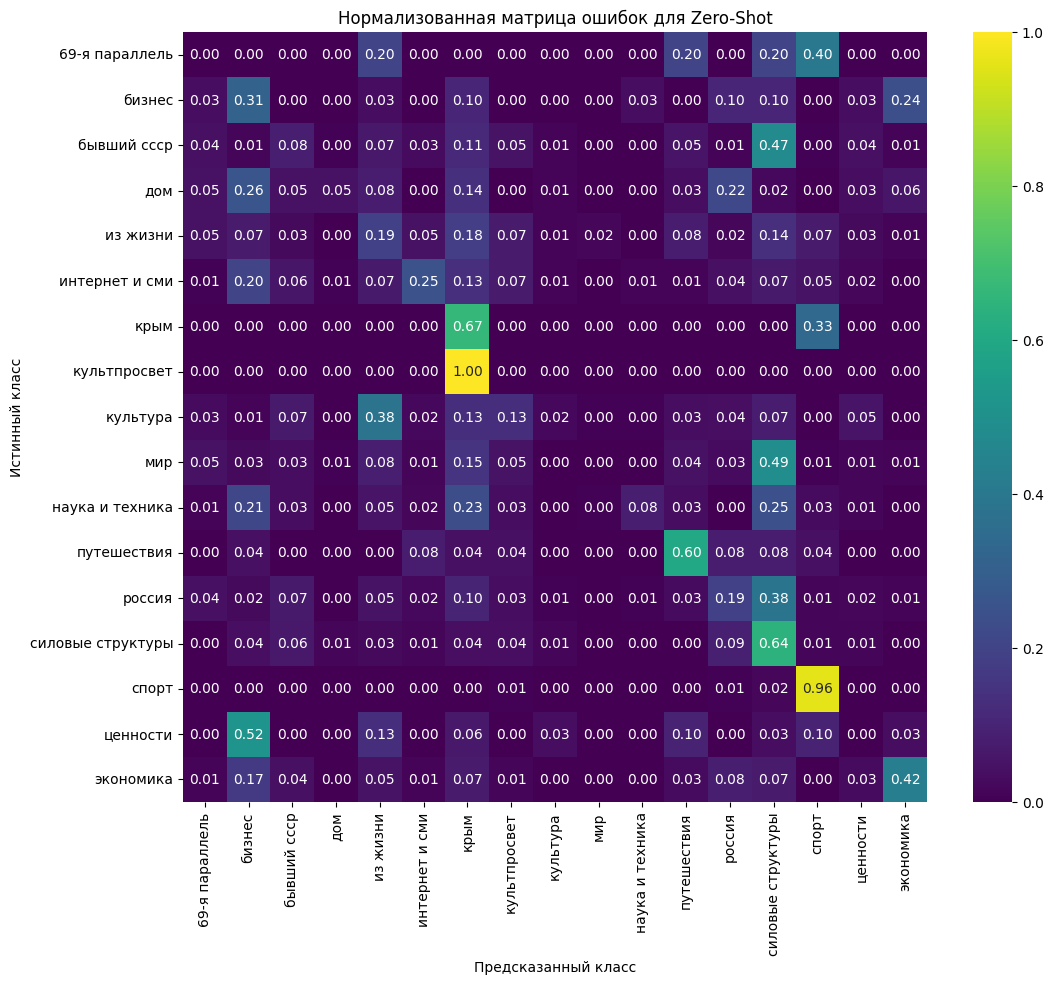

In [74]:
# --- 5. Сводная таблица и график результатов ---

# Сбор сводного dataframe
results_data = {
    "Модель": [
        "TF-IDF + LogisticRegression",
        "Sentence Transformers + LogisticRegression",
        "Zero-Shot Classification",
    ],
    "Accuracy": [test_acc_tfidf, test_acc_st, test_acc_zs],
    "F1-score (weighted)": [test_f1_tfidf, test_f1_st, test_f1_zs],
}
results_df = pd.DataFrame(results_data)
results_df_melted = results_df.melt(id_vars="Модель", var_name="Метрика", value_name="Значение")
display(results_df.round(4))

# Отрисовка сравнительного графика
plt.figure(figsize=(12, 7))
sns.barplot(data=results_df_melted, x="Модель", y="Значение", hue="Метрика")
plt.title("Сравнение качества моделей на тестовой выборке")
plt.xticks(rotation=15, ha="right")
plt.ylabel("Значение метрики")
plt.xlabel("")
plt.legend(title="Метрика")
plt.tight_layout()
plt.show()


# --- 6. Визуализация нормализованных матриц ошибок ---
def plot_normalized_confusion_matrix(cm, class_names, title):
    # Нормализуем матрицу ошибок по строкам (по истинным значениям)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel("Истинный класс")
    plt.xlabel("Предсказанный класс")
    plt.show()


# Отрисовка нормализованных матриц ошибок
plot_normalized_confusion_matrix(
    cm_tfidf, topic_to_id_map.keys(), "Нормализованная матрица ошибок для TF-IDF + LogisticRegression"
)
plot_normalized_confusion_matrix(
    cm_st, topic_to_id_map.keys(), "Нормализованная матрица ошибок для Sentence Transformers + LogisticRegression"
)
plot_normalized_confusion_matrix(cm_zs, topic_to_id_map.keys(), "Нормализованная матрица ошибок для Zero-Shot")

## Выводы

### 1. TF-IDF / Sentence Transformers

Модели, использующие `TF-IDF` и `Sentence Transformers`, показали сопоставимые результаты.

* **Эффективность на малой выборке:** На данном, относительно **малом наборе данных** (14.7к записей), TF-IDF оказался незначительно, чем использование эмбеддингов от предобученной трансформерной модели.
* **Анализ ошибок:** Анализ матриц ошибок показал, что обе модели допускают ошибки на одних и тех же семантически близких классах ( "Бизнес" <-> "Экономика"). Это указывает на то, что сложность для обеих моделей представляет естественная неоднозначность самих данных и только подчеркивает их способность успешно улавливать смысловую близость слов.

### 2. Zero-Shot

Подход `Zero-Shot Classification` ожидаемо показал неудовлетворительные результаты.

Эти результаты следует интерпретировать с осторожностью по нескольким причинам:

1.  **Высокая сложность:** Классификация проводилась по 17 классам. Многие из этих классов семантически близки (например, 'Бизнес' и 'Экономика', 'Россия' и 'Крым'), что создает высокую неоднозначность для модели, работающей без специального дообучения.
2.  **Несоответствие поставленной задаче:** Исходный датасет использует одноклассовую разметку, хотя одна новость объективно может принадлежать к нескольким темам.
3.  **Гипотеза по улучшению:** Можно предположить, что качество Zero-Shot классификации значительно возрастет, если изменить постановку задачи на multi-label классификацию (предсказание нескольких тем для одной новости) и использовать соответствующую метрику, например, **Precision@k** (доля верных предсказаний в топ-k).